# DQN Training
Training a DQN agent using custom gym environment and keras-rl2.

# Imports

In [42]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from gym import Env
from gym.spaces import Discrete, Box

from rl.agents import DQNAgent
from rl.policy import MaxBoltzmannQPolicy, BoltzmannQPolicy, LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

## Functions

In [43]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w

# Environment

## Loading Shape Class

In [44]:
import sys  
sys.path.insert(0, "E:\Projects\Python\TetrisRoyaleRL")

from settings import *
from game_env.shapes import Shape
from game_env.game_env import GameEnv

## Reworking the Environment

## Define new functions

In [45]:
def heuristic(self):
        temp_map = self.map
        # sum of heights
        heights = 24 - np.argmax(temp_map[:, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS] == 1, axis=0)
        sum_hights = heights.sum()

        # bumpiness
        bumpiness = 0
        for i in range(heights.shape[0] - 1):
            bumpiness += (heights[i] - heights[i + 1]) ** 2

        # complete rows
        temp_map = temp_map[GAME_SHAPE_TOP_HIDDEN: -GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
        complete_rows = (np.where(temp_map.sum(axis=1) == 10)[0]).size

        # count of holes
        holes = 0
        for i in range(1, temp_map.shape[0]):
            for j in range(temp_map.shape[1]):
                if temp_map[i, j] == 0 and temp_map[i-1, j] == 1:
                    holes += 1

        total = -0.6 * sum_hights \
                + 0.75 * complete_rows \
                - 0.35 * holes \
                - 0.15 * bumpiness
        return total

In [46]:
def new_state_observe(self):
        # observable map
        temp_map = self.map[GAME_SHAPE_TOP_HIDDEN:-GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS].copy()
        
        # observation of cur shape on map
        temp_shape = np.zeros(self.map.shape)
        x0 = self.shape.x
        y0 = int(self.shape.y)
        this_shape = self.shape.get_shape()
        temp_shape[y0: y0 + this_shape.shape[0], x0: x0 + this_shape.shape[1]] += this_shape
        temp_shape = temp_shape[GAME_SHAPE_TOP_HIDDEN:-GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
        
        # next shape on map, assuming y0 = 0
        temp_next_shape = np.zeros((20, 10))
        x0 = self.next_shape.x - GAME_SHAPE_BORDERS
        next_shape = self.next_shape.get_shape()
        temp_next_shape[0: next_shape.shape[0], x0: x0 + next_shape.shape[1]] += next_shape

        return np.stack([temp_map, temp_shape, temp_next_shape], axis=-1).astype(np.float32)

In [47]:
def reward_alive(self):
    return 0.5

## Assign new functions

In [48]:
GameEnv._state_observe = new_state_observe
GameEnv._reward_after_lock_figure = heuristic
GameEnv._reward_for_alive = reward_alive

class GameEnv(Env):
    def __init__(self):
        # spaces
        self.action_space = Discrete(5)
        self.observation_space = Box(low=0.0, high=1.0, shape=(20, 10, 3))
        
        # state
        self.game_over = None

        # coord
        self.map = None

        # shape
        self.shape = None
        self.next_shape = None

        # init env
        self._state_gen()

    def _state_gen(self):
        self.game_over = False
        
        self.map = np.ones((GAME_SHAPE_TOP_HIDDEN + 20 + GAME_SHAPE_BORDERS,
                            GAME_SHAPE_BORDERS + 10 + GAME_SHAPE_BORDERS), dtype=np.int32)
        self.map[0: -GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS] = 0
        
        self.shape = Shape()
        self.next_shape = Shape()

    def _state_observe(self):
        # observable map
        temp_map = self.map[GAME_SHAPE_TOP_HIDDEN:-GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS].copy()
        
        # observation of cur shape on map
        temp_shape = np.zeros(self.map.shape)
        x0 = self.shape.x
        y0 = int(self.shape.y)
        this_shape = self.shape.get_shape()
        temp_shape[y0: y0 + this_shape.shape[0], x0: x0 + this_shape.shape[1]] += this_shape
        temp_shape = temp_shape[GAME_SHAPE_TOP_HIDDEN:-GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
        
        # next shape on map, assuming y0 = 0
        temp_next_shape = np.zeros((20, 10))
        x0 = self.next_shape.x - GAME_SHAPE_BORDERS
        next_shape = self.next_shape.get_shape()
        temp_next_shape[0: next_shape.shape[0], x0: x0 + next_shape.shape[1]] += next_shape

        return np.stack([temp_map, temp_shape, temp_next_shape], axis=-1).astype(np.float32)

    def render(self, mode="human"):
        pass
    
    def reset(self):
        # restart state
        self._state_gen()
        # not terminal
        return self._state_observe()

    def step(self, action):
        reward = 0
        # 0 is skip
        # 1 is left
        if action == 1:
            if self.can_move(self.shape.x - 1, int(self.shape.y), self.shape.get_shape()):
                self.shape.x -= 1
            else:
                #reward -= 1
                pass
        # 2 is right
        elif action == 2:
            if self.can_move(self.shape.x + 1, int(self.shape.y), self.shape.get_shape()):
                self.shape.x += 1
            else:
                #reward -= 1
                pass
        # 3 is down
        elif action == 3:
            if self.can_move(self.shape.x, int(self.shape.y + 1), self.shape.get_shape()):
                self.shape.y += 1
            else:
                #reward -= 1
                pass
        # 4 is rotate
        elif action == 4:
            if self.can_move(self.shape.x, int(self.shape.y), self.shape.get_rotated()):
                self.shape.rotate()
            else:
                #reward -= 1
                pass
        # move down
        if self.can_move(self.shape.x, int(self.shape.y + FALL_SPEED), self.shape.get_shape()):
            self.shape.y += FALL_SPEED
        else:
            self.lock_figure()
            #reward += self.lock_figure()
            reward += self.heuristic()

            #reward for height of locked shapes
            #height = self.map[GAME_SHAPE_TOP_HIDDEN: -GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
            #height = np.where(height.sum(axis=1) == 0)[0]
            #reward += (height.size) / 5
        
        # reward for cleared rows
        reward += self.remove_full_rows()
        
        return self._state_observe(), reward, self.game_over, {}


    def at(self, x, y):
        return self.map[GAME_SHAPE_TOP_HIDDEN + y, GAME_SHAPE_BORDERS + x]

    def can_move(self, x0, y0, figure):
        temp = self.map.copy()
        temp[int(y0): int(y0 + figure.shape[0]), x0: x0 + figure.shape[1]] += figure
        if 2 in temp:
            return False
        else:
            return True

    def lock_figure(self):
        x = self.shape.x
        y = int(self.shape.y)
        figure = self.shape.get_shape()
        self.map[y: y + figure.shape[0], x: x + figure.shape[1]] += figure
        self.shape = self.next_shape
        self.next_shape = Shape()
        if y < GAME_SHAPE_TOP_HIDDEN:
            self.game_over = True
        return y - GAME_SHAPE_TOP_HIDDEN


    def remove_full_rows(self):
        reward = 0
        full = self.map[GAME_SHAPE_TOP_HIDDEN: -GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
        full = np.where(full.sum(axis=1) == 10)[0]
        if full.size > 0:
            reward = full.size * 10

            # to get indexes of the game screen
            full = full + GAME_SHAPE_TOP_HIDDEN

            # remove full rows
            self.map[full, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS] = 0

            # get non-empty rows
            partial = self.map[GAME_SHAPE_TOP_HIDDEN: -GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
            partial = np.where(partial.sum(axis=1) != 0)[0]

            # if there are levitating non-empty rows
            if partial.size > 0:
                # get their indexes
                partial = partial + GAME_SHAPE_TOP_HIDDEN
                bottom = self.map.shape[0] - GAME_SHAPE_BORDERS
                # move them to bottom
                self.map[bottom-partial.size: bottom, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS] = \
                    self.map[partial, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
                # everything above must be cleared
                self.map[0: bottom-partial.size, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS] = 0
        return reward
        
    def heuristic(self):
        temp_map = self.map
        # sum of heights
        heights = 24 - np.argmax(temp_map[:, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS] == 1, axis=0)
        sum_hights = heights.sum()

        # bumpiness
        bumpiness = 0
        for i in range(heights.shape[0] - 1):
            bumpiness += abs(heights[i] - heights[i + 1])

        # complete rows
        temp_map = temp_map[GAME_SHAPE_TOP_HIDDEN: -GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
        complete_rows = (np.where(temp_map.sum(axis=1) == 10)[0]).size

        # count of holes
        holes = 0
        for i in range(1, temp_map.shape[0]):
            for j in range(temp_map.shape[1]):
                if temp_map[i, j] == 0 and temp_map[i-1, j] == 1:
                    holes += 1

        total = -0.75 * sum_hights \
                + 0.75 * complete_rows \
                - 0.35 * holes \
                - 0.2 * bumpiness
        return total

## Create env

In [60]:
env = GameEnv()
env.observation_space = Box(low=0.0, high=1.0, shape=(20, 10, 3))
env.gravity = 1

## Test Random

In [61]:
episodes = 25
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    steps = 0
    while not done:
        action = np.random.randint(0, 5)
        n_state, reward, done, info = env.step(action)
        score+=reward
        steps +=1
    print("Episode: {}, Score: {}, Steps: {}".format(episode, score, steps))

Episode: 1, Score: -1092.0499999999997, Steps: 1374
Episode: 2, Score: -1157.5499999999997, Steps: 1132
Episode: 3, Score: -871.7499999999999, Steps: 1577
Episode: 4, Score: -1125.3500000000001, Steps: 1375
Episode: 5, Score: -843.3, Steps: 1455
Episode: 6, Score: -886.8, Steps: 1534
Episode: 7, Score: -1021.05, Steps: 1713
Episode: 8, Score: -378.19999999999993, Steps: 1079
Episode: 9, Score: -503.79999999999995, Steps: 1118
Episode: 10, Score: -791.9999999999999, Steps: 1470
Episode: 11, Score: -850.6999999999998, Steps: 1323
Episode: 12, Score: -818.3999999999999, Steps: 1308
Episode: 13, Score: -518.4, Steps: 1332
Episode: 14, Score: -1270.2999999999997, Steps: 1912
Episode: 15, Score: -210.8, Steps: 917
Episode: 16, Score: -706.05, Steps: 983
Episode: 17, Score: -602.0, Steps: 1642
Episode: 18, Score: -459.99999999999994, Steps: 1521
Episode: 19, Score: -798.4, Steps: 1520
Episode: 20, Score: -1065.4, Steps: 1404
Episode: 21, Score: -562.7, Steps: 1062
Episode: 22, Score: -1000.14

## Test do-nothing

In [51]:
episodes = 25
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    steps = 0
    while not done:
        action = -1
        n_state, reward, done, info = env.step(action)
        score+=reward
        steps +=1
    print("Episode: {}, Score: {}, Steps: {}".format(episode, score, steps))

Episode: 1, Score: 188.50000000000006, Steps: 3009
Episode: 2, Score: 52.5, Steps: 3276
Episode: 3, Score: 634.6000000000001, Steps: 4147
Episode: 4, Score: 28.900000000000148, Steps: 2649
Episode: 5, Score: 271.09999999999997, Steps: 3506
Episode: 6, Score: 310.0000000000001, Steps: 3064
Episode: 7, Score: 467.59999999999985, Steps: 2647
Episode: 8, Score: 96.00000000000003, Steps: 3355
Episode: 9, Score: 515.55, Steps: 2849
Episode: 10, Score: 271.20000000000016, Steps: 3611
Episode: 11, Score: 232.5, Steps: 3198
Episode: 12, Score: -18.399999999999977, Steps: 3196
Episode: 13, Score: -509.9499999999998, Steps: 3346
Episode: 14, Score: 535.6499999999999, Steps: 2848
Episode: 15, Score: 464.34999999999997, Steps: 3945
Episode: 16, Score: 530.8999999999999, Steps: 3491
Episode: 17, Score: 421.7000000000001, Steps: 3651
Episode: 18, Score: 361.8, Steps: 3129
Episode: 19, Score: 579.9000000000001, Steps: 3089
Episode: 20, Score: 81.2000000000001, Steps: 2688
Episode: 21, Score: 456.45000

# Nural Network and Agent

## Build model

In [52]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [53]:
def build_model():
    return tf.keras.Sequential([
    # 1 state, 20 rows, 10 cols, 3 matricies: locked, falling and next figures
    layers.Input(shape=(1, 20, 10, 3)),
    layers.Reshape(target_shape=(20, 10, 3)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    
    layers.Dense(32),
    layers.Activation("relu"),
    
    layers.Dense(16),
    layers.Activation("relu"),
    
    layers.Dense(5)])

In [54]:
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 20, 10, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 10, 32)        896       
                                                                 
 activation_8 (Activation)   (None, 20, 10, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 5, 32)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 5, 64)         18496     
                                                                 
 activation_9 (Activation)   (None, 10, 5, 64)         0         
                                                      

## Agent

In [55]:
env.observation_space.shape, env.action_space.n

((20, 10, 3), 5)

In [56]:
def build_agent(model):
    #policy = MaxBoltzmannQPolicy()
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 
                              attr='eps',
                              value_max=1.0,
                              value_min=.01,
                              value_test=.01,
                              nb_steps=75000)
    #policy = EpsGreedyQPolicy(0.2)
    memory = SequentialMemory(limit=5000, window_length=1)
    dqn = DQNAgent(model=model, 
        memory=memory,
        policy=policy,
        nb_actions=5,
        nb_steps_warmup=256,
        batch_size=128,
        target_model_update=1000,
        enable_double_dqn=True,
        enable_dueling_network=True)
    return dqn

In [57]:
dqn = build_agent(model)
dqn.compile(tf.keras.optimizers.Adam(learning_rate=0.00001, clipnorm=1.0), metrics=["mean_squared_error"])

In [58]:
dqn.load_weights("saved/dqn_v15.h5")

from keras import backend as K
print(K.eval(dqn.model.optimizer.learning_rate))
K.set_value(dqn.model.optimizer.learning_rate, 0.00001)
print(K.eval(dqn.model.optimizer.learning_rate))

0.01
1e-05


## Training

In [59]:
history = dqn.fit(env, nb_steps=100000, visualize=False, verbose=1, log_interval=5000)

Training for 100000 steps ...
Interval 1 (0 steps performed)
5000/5000 [==============================] - 187s 37ms/step - reward: -0.4166
3 episodes - episode_reward: -763.167 [-912.700, -628.100] - loss: 25.232 - mean_squared_error: 722.778 - mean_q: -18.502 - mean_eps: 0.965

Interval 2 (5000 steps performed)
1504/5000 [========>.....................] - ETA: 2:12 - reward: -0.4833done, took 243.979 seconds


## Save Weights

In [ ]:
dqn.save_weights("saved/dqn_v16.h5", overwrite=True)

## Plot

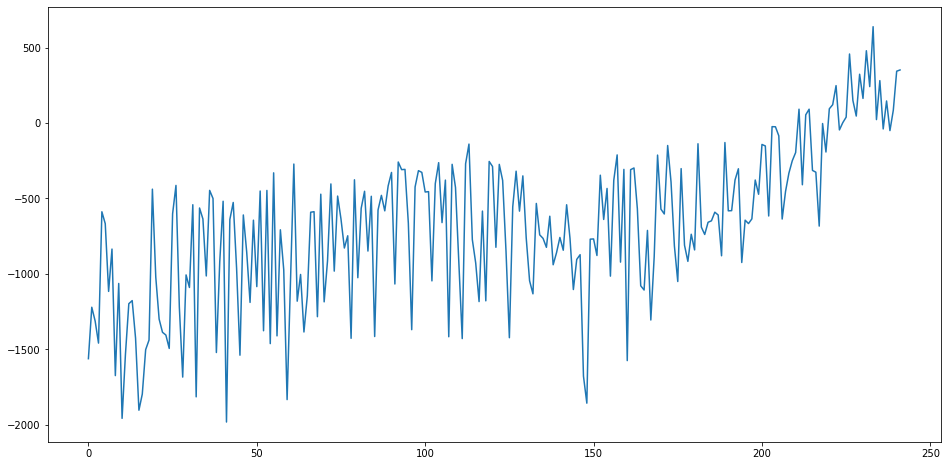

In [ ]:
# load history
full_hist = np.load("saved/history15.npy")
# concat old and new history
full_hist = np.concatenate((full_hist, np.array(history.history["episode_reward"])))
# save history
#np.save("saved/history15.npy", full_hist)

plt.rcParams["figure.figsize"] = (16, 8)
#plt.plot(moving_average(full_hist, 10))
plt.plot(full_hist)
#plt.plot(np.array(history.history["episode_reward"]))
plt.show()